# EDA of filtered data
Notebook for exploring and highlightning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

def change_directory_to_repo():
    """Changes working directory to the repository root folder."""
    current_dir = Path.cwd()
    for parent in current_dir.parents:
        # Repository is the first folder with the .git folder
        files = list(parent.glob(".git"))
        if files:
            os.chdir(str(parent))

change_directory_to_repo()

In [5]:
filtered = pd.read_csv('data/filtered/filtered.csv', index_col=0)

We have inbalanced dataset:

In [6]:
filtered['filtered_affinity'].value_counts()

0    5526
1     966
Name: filtered_affinity, dtype: int64

## Splitting

There are many ways of splitting our data. A simple way is a random split. The problem is that we can have very similar molecules in both train and test datasets. That will affect our decision in a way that our model became overfitted to the current dataset. That is why we prefer a homology-based split generally. We will cluster similar molecules and select whole clusters for different splits. 

In [35]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

In [36]:
fingerprints = []
for row in filtered.itertuples():
    smiles = row[1]
    molecule = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule,2,1024)
    fingerprints.append(fingerprint)

In [40]:
list_fp = [fp.ToList() for fp in fingerprints]
list_fp = np.stack(list_fp)
list_fp.shape

(6492, 1024)

In [46]:
def clusterize_fingerprints(fps, cutoff=0.2):
    # See https://rdkit.readthedocs.io/en/latest/Cookbook.html#clustering-molecules
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs


In [47]:
cs = clusterize_fingerprints(fingerprints)

Let's visualize the three biggest clusters

In [51]:
id_to_take = []
cluster_number = []
for cluster_num, cluster in enumerate(cs[:3]):
    for id in cluster:
        id_to_take.append(id)
        cluster_number.append(cluster_num)

taken_fp = []
for id in id_to_take:
    taken_fp.append(list_fp[id])

/home/simon/miniconda3/envs/gero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

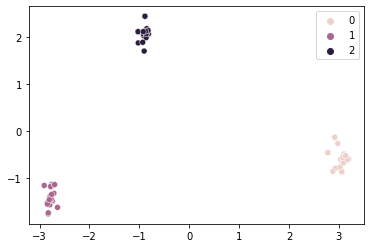

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings = pca.fit_transform(taken_fp).transpose()
sns.scatterplot(embeddings[0], embeddings[1], hue=cluster_number)

Indeed, clustering works.

In [63]:
from sklearn.model_selection import train_test_split

id_train_and_val, id_test = train_test_split(cs, test_size=0.2)
id_train, id_val = train_test_split(id_train_and_val, test_size=0.1)

In [64]:
def get_flattened_list(list_of_tuples):
    result = []
    for tuple in list_of_tuples:
        result.extend(tuple)
    return result

id_train = get_flattened_list(id_train)
id_val = get_flattened_list(id_val)
id_test = get_flattened_list(id_test)

In [69]:
filtered.iloc[id_train]

,smiles,filtered_affinity
903,C[C@]12C(=O)OC(=O)[C@@]1(C)[C@@H]1CC[C@H]2O1,0
3492,Fc1ccc(Nc2nc(NCCN3CCOCC3)nc3[nH]ncc23)cc1,0
3945,CC(C)N(CCNC(=O)[C@H]1C[C@@H]1c1ccccc1)C(C)C,0
1095,CN1CCN(Cc2cccc3c2c(Cl)cn3S(=O)(=O)c2cccc(Cl)c2...,0
4302,CC(C)c1ccccc1OCCN1CCC(NS(=O)(=O)c2cccc(F)c2)CC1,0
...,...,...
2486,Nc1cc(F)ccc1C(=O)CCCN1CC[C@H]2[C@@H](C1)c1cccc...,1
2505,Nc1c(F)cccc1C(=O)CCCN1CC[C@H]2[C@@H](C1)c1cccc...,1
2506,Nc1ccc(F)cc1C(=O)CCCN1CC[C@H]2[C@@H](C1)c1cccc...,0
2511,Nc1cc(Br)ccc1C(=O)CCCN1CC[C@H]2[C@@H](C1)c1ccc...,0
